In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Cấu hình
plt.rcParams['font.size'] = 11
sns.set_palette("Set2")

print("📂 Đang tải dữ liệu...")
df_events = pd.read_csv('../data/udk_moodle_log.csv')
df_grades = pd.read_csv('../data/udk_moodle_all_grades.csv')
print(f"✅ Đã tải {len(df_events):,} events và {len(df_grades):,} grades")

📂 Đang tải dữ liệu...
✅ Đã tải 1,259,411 events và 20,317 grades


In [7]:
# Tính toán features với scale khác nhau
print("\n⚙️ Đang tính toán features...")

# Feature 1: Total events per user
user_events = df_events.groupby('userid').size().reset_index(name='total_events')

# Feature 2: Average grade
user_grades = df_grades[df_grades['finalgrade'] >= 0].groupby('userid')['finalgrade'].mean().reset_index(name='avg_grade')

# Feature 3: Event diversity
user_diversity = df_events.groupby('userid')['eventname'].nunique().reset_index(name='event_diversity')

# Feature 4: Active days
df_events['datetime'] = pd.to_datetime(df_events['timecreated'], unit='s')
user_active_days = df_events.groupby('userid')['datetime'].agg(
    lambda x: (x.max() - x.min()).days
).reset_index(name='active_days')

# Feature 5: Number of courses
user_courses = df_events.groupby('userid')['courseid'].nunique().reset_index(name='num_courses')

# Merge features
user_features = user_events.merge(user_grades, on='userid', how='left')
user_features = user_features.merge(user_diversity, on='userid', how='left')
user_features = user_features.merge(user_active_days, on='userid', how='left')
user_features = user_features.merge(user_courses, on='userid', how='left')
user_features = user_features.fillna(0)

print("\n📊 Features Statistics:")
features_for_viz = ['total_events', 'avg_grade', 'event_diversity', 'active_days', 'num_courses']
print(user_features[features_for_viz].describe())


⚙️ Đang tính toán features...

📊 Features Statistics:
       total_events    avg_grade  event_diversity  active_days  num_courses
count   1110.000000  1110.000000      1110.000000  1110.000000  1110.000000
mean    1134.604505     7.429668        27.613514   113.019820     9.181081
std     1781.992533     2.153648        11.130799    33.980655     3.203723
min        1.000000     0.000000         1.000000     0.000000     1.000000
25%      303.750000     6.909091        21.000000   105.000000     7.000000
50%      624.500000     8.090909        28.000000   125.000000     9.000000
75%     1244.250000     8.800000        35.000000   137.000000    11.000000
max    30770.000000    10.000000        78.000000   145.000000    29.000000


In [8]:
# Chuẩn bị data
X_original = user_features[features_for_viz].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

df_original = pd.DataFrame(X_original, columns=features_for_viz)
df_scaled = pd.DataFrame(X_scaled, columns=features_for_viz)


💾 Đang lưu biểu đồ...
✅ Đã lưu: challenge_2_scale_imbalance.png
✅ Đã lưu: challenge_2_scale_imbalance.pdf


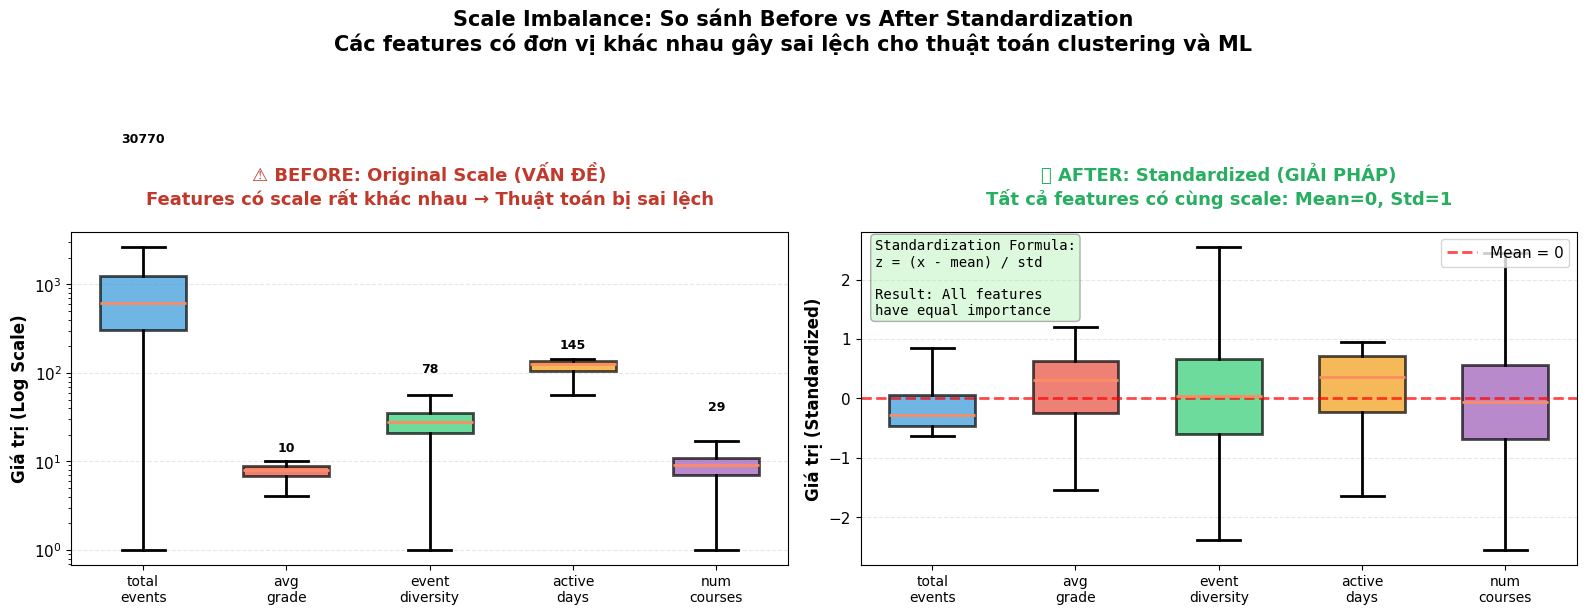


🎉 HOÀN THÀNH!


In [9]:
# Tạo biểu đồ so sánh Before vs After Standardization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# ============================================================================
# Panel 1: BEFORE - Original scale (VẤN ĐỀ)
# ============================================================================
ax1 = axes[0]
positions = np.arange(len(features_for_viz))
bp_data = [df_original[col].dropna() for col in features_for_viz]

bp = ax1.boxplot(bp_data, positions=positions, widths=0.6, patch_artist=True,
                 showfliers=False)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_linewidth(2)

for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], linewidth=2)

ax1.set_xticks(positions)
ax1.set_xticklabels([f.replace('_', '\n') for f in features_for_viz], fontsize=10)
ax1.set_ylabel('Giá trị (Log Scale)', fontweight='bold', fontsize=12)
ax1.set_title('⚠️ BEFORE: Original Scale (VẤN ĐỀ)\nFeatures có scale rất khác nhau → Thuật toán bị sai lệch',
             fontsize=13, fontweight='bold', pad=20, color='#c0392b')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_yscale('log')

# Thêm annotation về max values
for i, col in enumerate(features_for_viz):
    max_val = df_original[col].max()
    ax1.text(i, max_val * 1.2, f'{max_val:.0f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# ============================================================================
# Panel 2: AFTER - Standardized (GIẢI PHÁP)
# ============================================================================
ax2 = axes[1]
bp_scaled_data = [df_scaled[col].dropna() for col in features_for_viz]
bp_scaled = ax2.boxplot(bp_scaled_data, positions=positions, widths=0.6,
                        patch_artist=True, showfliers=False)

for patch, color in zip(bp_scaled['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_linewidth(2)

for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp_scaled[element], linewidth=2)

ax2.set_xticks(positions)
ax2.set_xticklabels([f.replace('_', '\n') for f in features_for_viz], fontsize=10)
ax2.set_ylabel('Giá trị (Standardized)', fontweight='bold', fontsize=12)
ax2.set_title('✅ AFTER: Standardized (GIẢI PHÁP)\nTất cả features có cùng scale: Mean=0, Std=1',
             fontsize=13, fontweight='bold', pad=20, color='#27ae60')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Mean = 0')
ax2.legend(fontsize=11, loc='upper right')

# Thêm text box giải thích
textstr = 'Standardization Formula:\nz = (x - mean) / std\n\nResult: All features\nhave equal importance'
props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.3)
ax2.text(0.02, 0.98, textstr, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', bbox=props, family='monospace')

# Tiêu đề chính
fig.suptitle('Scale Imbalance: So sánh Before vs After Standardization\nCác features có đơn vị khác nhau gây sai lệch cho thuật toán clustering và ML',
             fontsize=15, fontweight='bold', y=1.02)

plt.tight_layout()

# Lưu file
print("\n💾 Đang lưu biểu đồ...")
plt.savefig('challenge_2_scale_imbalance.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Đã lưu: challenge_2_scale_imbalance.png")

plt.savefig('challenge_2_scale_imbalance.pdf', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Đã lưu: challenge_2_scale_imbalance.pdf")

plt.show()

print("\n🎉 HOÀN THÀNH!")

## Kết luận

Biểu đồ so sánh rõ ràng:

**BEFORE (Trái - Đỏ):**
- Features có scale rất khác nhau (chênh lệch hàng trăm lần)
- `total_events` ~1000 vs `avg_grade` ~10
- Thuật toán clustering bị "át" bởi features có scale lớn

**AFTER (Phải - Xanh):**
- Tất cả features có cùng scale (mean=0, std=1)
- Thuật toán xử lý công bằng tất cả features
- Kết quả clustering chính xác hơn